## Load Data From DB

In [1]:
import sqlalchemy
from data import settings
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String

engine = sqlalchemy.create_engine(settings.DB_TYPE + settings.DB_USER + ":" + settings.DB_PASSWORD + "@" + settings.DB_URL + ":" + settings.DB_PORT + "/" + settings.DB_NAME, echo=settings.QUERY_ECHO)
Session = sessionmaker(bind=engine)
session = Session()
Base = declarative_base()

class Reviews(Base):
    # table name:
    __tablename__ = 'reviews'
    # table column:
    idx = Column(Integer, primary_key=True)
    app_id = Column(String)
    app_name = Column(String)
    review_id = Column(String)
    title = Column(String)
    author = Column(String)
    author_url = Column(String)
    version = Column(String)
    rating = Column(String)
    review = Column(String)
    category = Column(String)

Base.metadata.create_all(engine)

In [2]:
cols = ['app_id', 'app_name', 'title', 'review', 'rating', 'category', 'author_url', 'author']
data_dict = {i:[] for i in cols}
for row in session.query(Reviews.app_id, Reviews.app_name, Reviews.title, Reviews.review, Reviews.rating, 
                         Reviews.category, Reviews.author_url, Reviews.author):
    for i, col_name in enumerate(cols):
        data_dict[col_name].append(row[i])

In [3]:
data = pd.DataFrame(data_dict)
del data_dict

In [4]:
data.shape

(616758, 8)

In [5]:
data.category.unique()

array(['엔터테인먼트', '교육', '음악', '의학', '라이프 스타일', '게임', '뉴스', '날씨', '여행',
       '사진 및 비디오', '카탈로그', '소셜 네트워킹', '생산성', '건강 및 피트니스', '비즈니스', '스포츠',
       '내비게이션', '유틸리티', '도서', '참고', '금융', 'NaN', '음식 및 음료', '잡지 및 신문',
       'None'], dtype=object)

In [6]:
print('total reviews for each category\n-------------------------------')
for cat in data.category.unique():
    print('{0}: {1}'.format(cat, data.loc[data.category == cat].shape[0]))

total reviews for each category
-------------------------------
엔터테인먼트: 35808
교육: 33328
음악: 31417
의학: 5231
라이프 스타일: 45196
게임: 59374
뉴스: 10721
날씨: 12504
여행: 28900
사진 및 비디오: 45749
카탈로그: 2052
소셜 네트워킹: 39442
생산성: 47275
건강 및 피트니스: 39093
비즈니스: 23781
스포츠: 5246
내비게이션: 17922
유틸리티: 35598
도서: 24916
참고: 16883
금융: 41898
NaN: 594
음식 및 음료: 13309
잡지 및 신문: 509
None: 12


In [7]:
from collections import Counter, defaultdict
from konlpy.tag import Twitter, Kkma, Mecab
from pprint import pprint
import ujson
twitter = Twitter()
kkma = Kkma()
mecab = Mecab()
word_counter = Counter()

새로 생긴 명사를 추출한 후 트위터 분석기로 다시 분석?

In [8]:
data.columns

Index(['app_id', 'app_name', 'author', 'author_url', 'category', 'rating',
       'review', 'title'],
      dtype='object')

**문제정의**

리뷰로 앱의 평점을예측?

**가정:**

1) 평점과 리뷰는 정의 상관관계

In [9]:
docs = data.loc[:, ['app_id', 'review', 'rating']]
#docs = data.review.values.flatten()
del data

In [11]:
for i in docs.values[:3]:
    print(i)

['462725252' '맨날 보여준것만 계속 돌아가면서 보여주는군.. 징그럽다 진짜' '1']
['462725252' '잘 보고 있었는데 갑자기 없어진 이유가 뭐죠??????????????!!!?' '1']
['462725252' '해외에서도 쓸수있게해주세요ㅠㅠㅠㅠ' '5']


In [20]:
def save_docs(filename, docs):
    with open(filename, 'w', encoding='utf-8') as f:
        for doc in docs.values:
            print('{}\t{}\t{}'.format(doc[0], doc[1], doc[2]), file=f)
    print('done!')

In [21]:
id_list = docs.loc[:, 'app_id'].unique()
train_idx = int(len(id_list) * 0.8)
train_app_id = id_list[train_idx]
train_data_idx = docs.app_id[docs.app_id.isin([train_app_id])].index[-1]
train_data = docs.iloc[:train_data_idx, :]
test_data = docs.iloc[train_data_idx:, :]
len(train_data), len(test_data)

(489847, 126911)

In [22]:
save_docs('./data/train_docs.txt', train_data)
save_docs('./data/test_docs.txt', test_data)

done!
done!


In [35]:
texts = docs.values[:, 1]

In [36]:
min_count = 5   # 단어의 최소 출현 빈도수 (그래프 생성 시)
max_length = 10 # 단어의 최대 길이
wordrank_extractor = KRWordRank(min_count, max_length)

beta = 0.85    # PageRank의 decaying factor beta
max_iter = 10
verbose = True
keywords, rank, graph = wordrank_extractor.extract(texts, beta, max_iter, verbose)

scan vocabs ... 
num vocabs = 325932
done = 10


In [ ]:
graph

In [37]:
for word, r in sorted(keywords.items(), key=lambda x:x[1], reverse=True)[:30]:
    print('%8s:\t%.4f' % (word, r))

      너무:	828.6947
      삭제:	640.1840
      어플:	580.5323
      정말:	568.2289
     아이폰:	405.5209
      구매:	399.9822
      계속:	397.0825
      다시:	388.7428
      사용:	380.7750
      진짜:	362.1981
     좋아요:	339.8915
      다른:	314.6733
      좋은:	313.9213
      ㅠㅠ:	298.1130
     업데이:	257.8514
      안되:	254.6464
      많이:	252.6781
      부탁:	241.7240
     그리고:	235.1442
      빨리:	225.3209
      있는:	213.9592
      이거:	213.7671
      그냥:	213.6841
      있어:	208.8117
      결제:	206.9336
      바로:	204.1968
      ㅎㅎ:	199.0980
      다운:	192.0124
      기능:	177.3777
     어떻게:	175.4072


---

In [11]:
test_data.values[29436]

array(['1177522900', '진짜 쓸만합니다!', '5'], dtype=object)

In [8]:
error_data = test_data.values[29437][1]

In [13]:
len(error_data)

5880

---

doc = {문서번호: {app_id: , tokens: [], rating: }, $\cdots$}

doc = [app_id, [tokens], rating]

In [9]:
with open('./data/train_data_twitter.txt', 'r') as f:
    text = f.read()

test_docs = ujson.loads(text)

In [18]:
test_docs['2']

{'app_id': '462725252',
 'rating': '5',
 'tokens': ['해외/Noun',
  '에서도/Josa',
  '쓸/Verb',
  '수/PreEomi',
  '있/PreEomi',
  '게/Eomi',
  '해주세/Verb',
  '요/Eomi',
  'ㅠㅠㅠㅠ/KoreanParticle']}

In [24]:
tokens = [t for d in test_docs.values() for t in d['tokens']]
len(tokens)

1226567

In [25]:
import nltk
text = nltk.Text(tokens, name='NMSC')
print(text)

<Text: NMSC>


In [26]:
print(len(text.tokens))                 # returns number of tokens
print(len(set(text.tokens)))            # returns number of unique tokens
pprint(text.vocab().most_common(10))

1226567
36447
[('./Punctuation', 25546),
 ('요/Eomi', 23022),
 ('이/Josa', 17971),
 ('좋/Adjective', 15885),
 ('도/Josa', 13011),
 ('에/Josa', 12481),
 ('가/Josa', 11597),
 ('고/Eomi', 10519),
 ('을/Josa', 10194),
 ('다/Eomi', 9248)]


Punctuation, Eomi, Josa 제거하고 보자

In [33]:
tokens = [t for d in test_docs.values() for t in d['tokens'] \
          if t.split('/')[1] not in ['Punctuation', 'Josa', 'Eomi', 'PreEomi']]
len(tokens)

798499

In [34]:
text = nltk.Text(tokens, name='NMSC')
print(text)
print(len(text.tokens))                 # returns number of tokens
print(len(set(text.tokens)))            # returns number of unique tokens
pprint(text.vocab().most_common(10))

<Text: NMSC>
798499
34734
[('좋/Adjective', 15885),
 ('삭제/Noun', 8019),
 ('앱/Noun', 7867),
 ('구매/Noun', 7150),
 ('어플/Noun', 7020),
 ('너무/Noun', 5064),
 ('내/Determiner', 4760),
 ('되/Verb', 4534),
 ('역/Noun', 4405),
 ('안/VerbPrefix', 4281)]


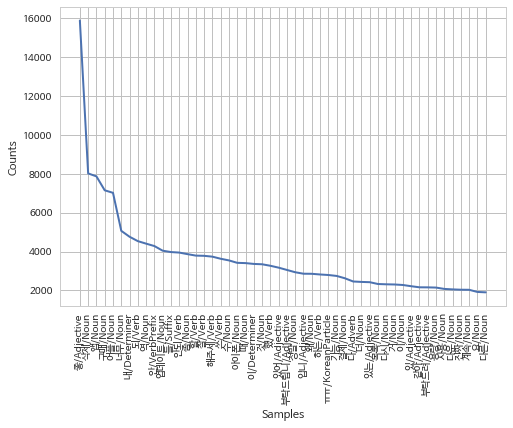

In [35]:
text.plot(50)

In [78]:
docs_a = []
for k, doc in test_docs.items():
    if doc['app_id'] == '447689011':
        docs_a.append([doc['tokens'], doc['rating']])

In [85]:
docs_train = []
for k, doc in test_docs.items():
    if doc['app_id'] != '447689011':
        docs_train.append([doc['tokens'], [doc['rating']]])

In [79]:
from gensim.models import doc2vec

Using TensorFlow backend.


In [86]:
doc_vectorizer = doc2vec.Doc2Vec(size=300, alpha=0.025, min_alpha=0.025, seed=1234)
doc_vectorizer.build_vocab(docs_train)

AttributeError: 'list' object has no attribute 'words'

---

In [38]:
for doc in docs:
    for word in doc.split():
        n = len(word)
        for e in range(1, n+1):
            word_counter[word[:e]] += 1

In [46]:
word = '해외에서도'
n = len(word)

for e in range(2, n+1):
    w = word[:e]
    f = word_counter[w]
    p = f/word_counter[w[:e-1]]
    print('{:6}, f={}, p={:.2}'.format(w, f, p))

해외    , f=2024, p=0.033
해외에   , f=464, p=0.23
해외에서  , f=349, p=0.75
해외에서도 , f=44, p=0.13


In [10]:
from soynlp.word import WordExtractor

In [11]:
word_extractor = WordExtractor()

In [12]:
word_extractor.train(docs)

training was done. used memory 2.217 Gbse memory 2.630 Gb


In [13]:
words = word_extractor.extract()

all cohesion probabilities was computed. # words = 290779
all branching entropies was computed # words = 328921
all accessor variety was computed # words = 328921


In [15]:
from soynlp.tokenizer import LTokenizer, MaxScoreTokenizer, RegexTokenizer

In [16]:
scores = {w:s.cohesion_forward for w, s in words.items()}
tokenizer1 = LTokenizer(scores=scores)
tokenizer2 = MaxScoreTokenizer(scores=scores)
tokenizer3 = RegexTokenizer()

In [24]:
tokenizer3.tokenize(docs[5913])

['돈주고',
 '삿는데',
 '그것도',
 '없고',
 '미치겟네',
 '그것도',
 '몇배차이입니까',
 '아',
 '업데이트좀',
 '단어없는게',
 '너무',
 '마니요',
 '다른건',
 '다',
 '좋은디']

In [19]:
from soynlp.noun import LRNounExtractor

In [26]:
noun_extractor = LRNounExtractor(min_count=50)
nouns = noun_extractor.train_extract(docs, minimum_noun_score=0.8)

used default noun predictor; Sejong corpus predictor
used noun_predictor_sejong
2398 r features was loaded
scanning completed
(L,R) has (28860, 16550) tokens
building lr-graph completed

In [ ]:
from soynlp.pos import 